# Word-audio ZSL evaluation

To evaluate our trained model, we first construct the model and load the saved weights.


## 1. Load the trained model

In [51]:
from zsl.model import WordAudioSiameseNetwork
from zsl.loss import TripletLoss
from zsl.dataset import WordAudioDataset
from zsl.data_prep import prepare_zsl_split_word_audio
from zsl.transforms import get_transforms
from zsl.model_manager import ModelManager
from zsl.utils import *

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
siamese_network = WordAudioSiameseNetwork().to(device)
triplet_loss = TripletLoss(0.5).to(device)
_, mel_transform = get_transforms()

In [5]:
optimizer_siamese = optim.Adam(siamese_network.parameters(), lr=0.01)
exp_lr_scheduler = ReduceLROnPlateau(
    optimizer_siamese, 
    mode='min', 
    factor=0.2, 
    patience=5, 
    verbose=True
)

In [6]:
curr_model = ModelManager(
    siamese_network, 
    triplet_loss, 
    optimizer_siamese, 
    exp_lr_scheduler, 
    device
)

In [7]:
curr_model.load_model('./checkpoints/word_audio_221129/w_ep-00195_l-0.0308.pth')

Loading model done: ./checkpoints/word_audio_221129/w_ep-00195_l-0.0308.pth


## 2. Prepare our data splits

In [9]:
(
    seen_word_classes,
    seen_audio_X_train, 
    seen_audio_y_train, 
    seen_audio_X_test, 
    seen_audio_y_test,
    unseen_word_classes,
    unseen_audio_X_train, 
    unseen_audio_y_train, 
    unseen_audio_X_test, 
    unseen_audio_y_test,
    inst_word_emb_dict
) = prepare_zsl_split_word_audio()

## 3. Seen class prediction (supervised learning)


### 3-1) Prepare the audio and image data from the seen classes.


In [10]:
seen_word_audio_dataset_tr = WordAudioDataset(
    audio_path_list = seen_audio_X_train,
    audio_label_list = seen_audio_y_train,
    audio_transform = mel_transform,
    curr_word_classes = seen_word_classes,
    word_emb_dict = inst_word_emb_dict
)
seen_word_audio_dataset_ts = WordAudioDataset(
    audio_path_list = seen_audio_X_test,
    audio_label_list = seen_audio_y_test,
    audio_transform = mel_transform,
    curr_word_classes = seen_word_classes,
    word_emb_dict = inst_word_emb_dict
)

In [11]:
seen_word_audio_dataloaders = {}
seen_word_audio_dataloaders['train'] = DataLoader(
    seen_word_audio_dataset_tr,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)
seen_word_audio_dataloaders['test'] = DataLoader(
    seen_word_audio_dataset_ts,
    batch_size=16, 
    num_workers=8,
    shuffle=True
)

### 3-2) Compute the audio embeddings using ZSL model

In [12]:
(
    seen_ts_audio_embs, 
    seen_ts_word_embs, 
    seen_ts_labels, 
    seen_ts_loss
) = curr_model.infer_all(seen_word_audio_dataloaders, 'test')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:20<00:00, 21.14it/s]

test Loss: 0.0315


### 3-3) Get the word embeddings of seen classes on the ZSL embedding space.

In [17]:
seen_class_to_word_emb = dict()
for _c in list(set(seen_audio_y_train)):
    for i in range(seen_ts_audio_embs.shape[0]):
        if seen_ts_labels[i] == _c:
            seen_class_to_word_emb[_c] = seen_ts_audio_embs[i]
            break

In [14]:
seen_class_to_word_embs = defaultdict(list)
for i in tqdm(range(seen_ts_audio_embs.shape[0])):
    seen_class_to_word_embs[seen_ts_labels[i]].append(seen_ts_word_embs[i])

seen_class_to_mean_word_emb = {}
for _c in seen_class_to_word_embs:
    seen_class_to_mean_word_emb[_c] = seen_class_to_word_embs[_c][0] # same embeddings for all instances

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 455947.97it/s]


### 3-4) Evaluate the test set audio on seen classes (supervised learning evaluation)

In [18]:
correct = 0
for idx in range(seen_ts_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(seen_ts_audio_embs[idx], 0), 
                                                  seen_class_to_word_emb, 
                                                  seen_word_classes,
                                                  1)
    if seen_ts_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / seen_ts_audio_embs.shape[0])

Top-1 acc : 0.8283752860411899


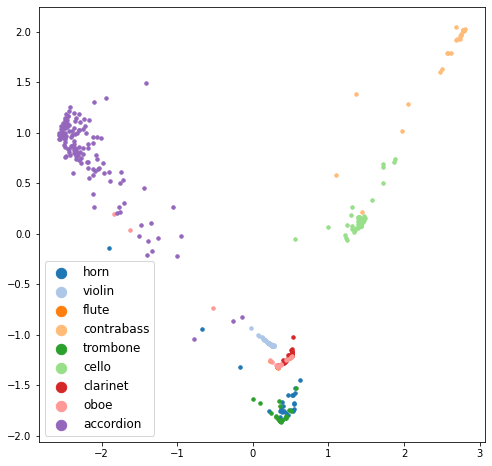

In [19]:
draw_pca(seen_ts_audio_embs, seen_ts_labels, seen_word_classes)

## 4. Unseen class prediction

### 4-1) Prepare the audio and word data from the unseen classes.

Note that, unlike many works from the literature, we are not going to use train/test split for unseen labeled audios. 

So, we're going to merge train and test set for unseen classes.

In [21]:
unseen_audio_X = unseen_audio_X_train + unseen_audio_X_test
unseen_audio_y = unseen_audio_y_train + unseen_audio_y_test
unseen_word_audio_dataset = WordAudioDataset(
    audio_path_list = unseen_audio_X,
    audio_label_list = unseen_audio_y,
    audio_transform = mel_transform,
    curr_word_classes = unseen_word_classes,
    word_emb_dict = inst_word_emb_dict
)

In [22]:
unseen_word_audio_dataloaders = {}
unseen_word_audio_dataloaders['all'] = DataLoader(
    unseen_word_audio_dataset,
    batch_size=16, 
    num_workers=8,
    shuffle=False
)

### 4-2) Compute the audio embeddings using ZSL model

In [24]:
(
    unseen_audio_embs, 
    unseen_word_embs, 
    unseen_labels, 
    unseen_loss
) = curr_model.infer_all(unseen_word_audio_dataloaders, 'all')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 738/738 [00:33<00:00, 21.85it/s]

all Loss: 0.4285


### 4-3) Compute the word embeddings using ZSL model

In [26]:
unseen_class_to_word_emb = dict()
for _c in list(set(unseen_audio_y)):
    for i in range(unseen_audio_embs.shape[0]):
        if unseen_labels[i] == _c:
            unseen_class_to_word_emb[_c] = unseen_audio_embs[i]
            break

In [27]:
unseen_class_to_word_emb.keys()

dict_keys([0, 1, 2, 3, 4])

### 4-5) Evaluate the audios on unseen classes (zero-shot evaluation)

In [29]:
correct = 0
for idx in range(unseen_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_audio_embs[idx], 0), 
                                            unseen_class_to_word_emb, 
                                            unseen_word_classes,
                                            1)
    if unseen_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / unseen_audio_embs.shape[0])

Top-1 acc : 0.3807588075880759


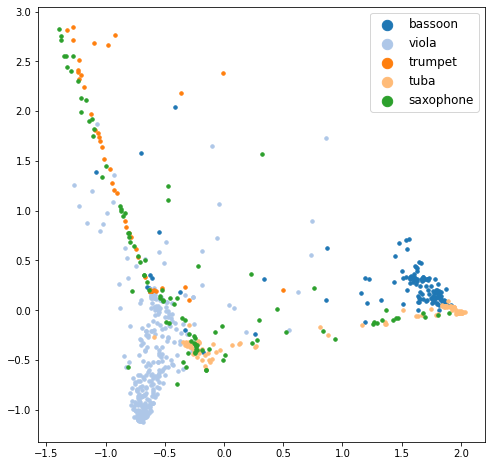

In [31]:
draw_pca(unseen_audio_embs, unseen_labels, unseen_word_classes)

## 5. Generalized ZSL evaluation

### 5-1) Concatenate the seen and unseen classes 

In [32]:
all_word_classes = seen_word_classes + unseen_word_classes

### 5-2) Relabel the audios from unseen classes 


In [40]:
added_unseen_labels = [_n + 9 for _n in unseen_labels]

### 5-3)  Get the word embedding vector for all classes

In [42]:
all_class_to_word_embs = {}
for _c in list(seen_class_to_word_emb.keys()):
    all_class_to_word_embs[_c] = seen_class_to_word_emb[_c]

for _c in list(unseen_class_to_word_emb.keys()):
    all_class_to_word_embs[_c+9] = unseen_class_to_word_emb[_c]

### 5-4) Evaluate the audio on seen + unseen classes (generalized zero-shot evaluation)

- audio : whole set from unseen dataset
- label : seen + unseen classes

In [37]:
all_class_to_word_embs = {}
for _c in list(seen_class_to_word_emb.keys()):
    all_class_to_word_embs[_c] = seen_class_to_word_emb[_c]

for _c in list(unseen_class_to_word_emb.keys()):
    all_class_to_word_embs[_c+9] = unseen_class_to_word_emb[_c]

In [49]:
correct = 0
for idx in range(unseen_audio_embs.shape[0]):
    curr_pred_indices, _ = nearest_neighbor_clf_k(np.expand_dims(unseen_audio_embs[idx], 0), 
                                            all_class_to_word_embs, 
                                            all_word_classes,
                                            1)
    if added_unseen_labels[idx] in curr_pred_indices:
        correct += 1
print('Top-1 acc :', correct / unseen_audio_embs.shape[0])

Top-1 acc : 0.13143631436314362


## 6. Visualize 

- test set seen class audio + whole set unseen class audio
- seen + unseen classes

In [47]:
all_audio_embs = np.concatenate([seen_ts_audio_embs, unseen_audio_embs])
all_labels = seen_ts_labels + added_unseen_labels

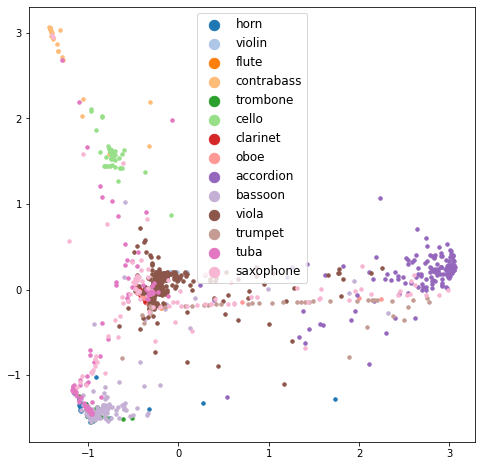

In [48]:
draw_pca(all_audio_embs, all_labels, all_word_classes)